In [2]:
%pip install simpy

In [3]:
import random
import simpy
import networkx as nx

## Define clases

### Message

In [4]:
class Message:
    def __init__(self, origin, destination, data):
        self.origin = origin
        self.destination = destination
        self.data = data
        self.route = []  # Lista para almacenar la ruta del mensaje
        self.multicast_route = {}
        self.multicast_origin_sent_destination = []
        self.hops_to_root = 0
        self.hops_from_root = 0
        self.last_hop = None

    def get_origin(self):
        return self.origin

    def get_destination(self):
        return self.destination
    
    def add_node_to_route(self, node):
        self.route.append(node)

    def remove_node_from_route(self):
        self.route.pop()

    def get_route(self):
        return self.route
    
    def print_route(self):
        if all(isinstance(route, list) for route in self.route):
            # Si self.route es una lista de listas
            for route in self.route:
                print(f"Route: {[node.id for node in route]}")
        else:
            # Si self.route es una lista simple
            print(f"Route: {[node.id for node in self.route]}")

    def add_node_to_multicast_route(self, id, node):
        current_route = self.multicast_route.get(id, []) 
        current_route.append(node)
        self.multicast_route[id] = current_route

    def get_multicast_route(self):
        result = []
        for route in self.multicast_route.values():
            result.append(route)
        return result
    
    def add_destination_to_multicast_origin_sent_destination(self, destination_id):
        self.multicast_origin_sent_destination.append(destination_id)

    def is_destination_in_multicast_origin_sent_destination(self, destination_id):
        return destination_id in self.multicast_origin_sent_destination
    
    def is_rpl_second_approach_message(self):
        return self.data == "RPL Second Approach: Movement Alert!"
    
    def add_routes_to_message(self, routes):
        self.route = routes

    def remove_node_if_is_a_destination(self, node_id):
        if node_id in self.destination:
            self.destination.remove(node_id)

    def are_still_destinations(self):
        return len(self.destination)
    
    def get_last_hop(self):
        return self.last_hop
    
    def change_last_hop(self, new_last_hop):
        self.last_hop = new_last_hop

    def change_origin(self, new_origin):
        self.origin = new_origin

    def __eq__(self, other):
        return self.origin == other.origin and self.destination == other.destination and self.data == other.data

    def __hash__(self):
        return hash((self.origin, self.destination, self.data))

### Node

In [5]:
class Node:
    def __init__(self, env, id, tx_range, verbose=False):
        self.env = env
        self.id = id
        self.tx_range = tx_range  # Transmission range to find neighbors

        self.neighbors = []
        self.children = [] 

        ## PARA ENVIO DE MENSAJES

        self.is_root = False  # Indica si soy la raíz del DODAG
        self.parent = None  # Padre en el DODAG (nodo hacia el cual reenviar mensajes)
        # self.dodag_id = None  # ID del DODAG
        self.rank = None
        self.preferred_parent = None

        # RPL MULTICAST
        self.mpl_domain = None  # MPL Domain al que pertenece el nodo
        self.received_messages = []  # Lista de mensajes recibidos
        self.senders = []

        env.process(self.run(verbose))

    def run(self, verbose):
        while True:
            yield self.env.timeout(random.uniform(1, 3))
            if self.rank:
                self.send_dio(verbose)

    def send_dio(self, verbose):
        for neighbor in self.neighbors:
            neighbor.receive_dio(self.rank, verbose)

    def receive_dio(self, rank, verbose):
        new_rank = 0 ## COMPUTE RANK
        if not self.rank or self.rank < new_rank:
            self.rank = new_rank
            self.update_preferred_parent(self, verbose)
            if verbose: print(f"Node {self.id} received DIO, setting rank to {self.rank}")
            self.send_dio()

    
    ## PARA ENVIO DE MENSAJES

    def set_as_root(self, verbose, dio=False):
        self.is_root = True
        self.rank = 0
        if verbose: print(f"Node {self.id} is the DODAG Root\n")
        if dio: self.send_dio(verbose)

    def is_dodag_root(self):
        return self.is_root
    
    def is_child_node(self, id):
        # Verifica si el ID proporcionado pertenece a algún hijo
        return any(child.id == id for child in self.children)
    
    def set_preferred_parent(self, parent):
        self.preferred_parent = parent

    def update_preferred_parent(self, parent, verbose):
        if self.preferred_parent is None or parent.rank < self.preferred_parent.rank:
            if self.preferred_parent:
                self.preferred_parent.children.remove(self)
            self.preferred_parent = parent
            parent.children.append(self)
            if verbose:
                print(f"Node {self.id} updated preferred parent to Node {parent.id}")
        
    def send_message_upwards(self, message, verbose, hops_to_root=0):
        message.add_node_to_route(self)
        if self.id == message.get_destination():
            message.hops_to_root = hops_to_root
            if verbose: print(f"Node {self.id}: Message delivered to destination {message.get_destination()} :)")
        else:
            # Enviar mensaje hacia arriba en el DODAG (hacia el preferred parent)
            if self.is_root:
                # Soy la raíz, proceso el mensaje aquí o lo reenvío hacia abajo
                message.remove_node_from_route()
                message.hops_to_root = hops_to_root
                if message.is_rpl_second_approach_message():
                    message.add_node_to_route(self)
                    self.forward_message_to_all(message, verbose)
                else:
                    self.send_message_downwards(message, verbose, 0)
            elif self.preferred_parent:
                if verbose: print(f"Node {self.id}: Message delivered to parent {self.preferred_parent}")

                if message.is_rpl_second_approach_message():
                    message.remove_node_if_is_a_destination(self.id)
                    if message.are_still_destinations():
                        self.preferred_parent.send_message_upwards(message, verbose, hops_to_root + 1) 
                else:
                    self.preferred_parent.send_message_upwards(message, verbose, hops_to_root + 1)
            else:
                if verbose: print(f"Node {self.id}: No preferred parent set to send message upwards.")
    
    def send_message_downwards(self, message, verbose, hops_from_root=0):
        message.add_node_to_route(self)
        if self.id == message.get_destination():
            message.hops_from_root = hops_from_root
            if verbose: print(f"Node {self.id}: Message delivered to destination {message.get_destination()}")
        else:
            # Enviar mensaje hacia abajo en el DODAG (hacia el destino final)
            shortest_path = self.compute_shortest_path_to_destination(message.get_destination())
            next_hop = shortest_path[1] if len(shortest_path) > 1 else None
            if next_hop is not None:
                if verbose: print(f"Node {self.id}: Message delivered to: {next_hop}")
                next_hop.send_message_downwards(message, verbose, hops_from_root + 1)
            else:
                if verbose: print(f"Node {self.id}: No route found to destination {message.get_destination()}")
    
    def compute_shortest_path_to_destination(self, destination):
        visited = set()
        queue = [[self]]
        
        while queue:
            path = queue.pop(0)
            node = path[-1]
            if node.id == destination:
                return path
            if node.id not in visited:
                for child in node.children:
                    new_path = list(path)
                    new_path.append(child)
                    queue.append(new_path)
                    visited.add(node.id)
        
        return []
    
    def forward_message_to_all(self, message, verbose):
        # tengo que mandar a todas las street lights
        routes = []
        street_lights = message.get_destination()

        # Caso en que la street_light destination sea hijo directo: no hace falta ir a la raiz
        remaining_destinations = []
        for street_light in street_lights:
            for child in self.children:
                if child.id == street_light:
                    # Si el destino es un hijo directo
                    routes.append([self.id, street_light])
            else:
                # Agregar a los destinos restantes que deben enviarse a través de la raíz
                remaining_destinations.append(street_light)

        for street_light in remaining_destinations:
            new_message = Message(self.id, street_light, message.data)
            self.send_message_downwards(new_message, verbose)
            routes.append(new_message.get_route())
        message.add_routes_to_message([message.get_route()] + routes)

    # RPL MULTICAST

    def get_mpl_domain(self):
        return self.mpl_domain
    
    def get_id(self):
        return self.id
    
    def add_sender(self, sender_id):
        self.senders.append(sender_id)

    def receive_message(self, message, verbose):
        if message not in self.received_messages:
            self.received_messages.append(message)
            if verbose: print(f"Node {self.id} received message from {message.get_origin()}")
            message.change_origin(self.id)
            self.forward_message(message, verbose)
        else:
            if verbose: print(f"Node {self.id} already received message to {message.get_destination()}")

    def forward_message(self, message, verbose):
        for neighbor in self.neighbors:
            if neighbor.get_mpl_domain() == self.mpl_domain and neighbor != message.get_origin():
                if (self.id == message.get_origin() and message.is_destination_in_multicast_origin_sent_destination(neighbor.get_id())) or (neighbor.get_id() == message.get_last_hop()) or (neighbor.get_id() in self.senders):
                    continue
                else:
                    message.add_destination_to_multicast_origin_sent_destination(neighbor.get_id())
                    self.mpl_domain.increase_message_count()
                    message_id = self.mpl_domain.get_message_count()
                    message.add_node_to_multicast_route(message_id, self.id)
                    message.add_node_to_multicast_route(message_id, neighbor.id)
                    message.change_last_hop(self.id)
                    neighbor.add_sender(self.id)
                    neighbor.receive_message(message, verbose)


    # PRINTING AND DEBUGGING

    def print_node_details(self):
        print(f"Node ID: {self.id}")
        print(f"Transmission Range: {self.tx_range}")
        print(f"Is Root: {self.is_root}")
        print(f"Neighbors: {[neighbor.id for neighbor in self.neighbors]}")
        print(f"Children: {[children.id for children in self.children]}")
        print(f"Parent: {self.parent.id if self.parent else None}")
        print(f"Preferred parent: {self.preferred_parent.id if self.preferred_parent else None}")
        print(f"Rank: {self.rank}")
        print(f"MPL Domain: {self.mpl_domain.id if self.mpl_domain else None}")
        print(f"Received Messages: {[(msg.get_origin(), msg.get_destination()) for msg in self.received_messages]}")
        print()

    def __str__(self):
        return f"Node {self.id}"

### StreetLight

In [6]:
class StreetLight(Node):
    def __init__(self, env, id, tx_range, mpl_domain_address=None):
        super().__init__(env, id, tx_range)
        self.is_street_light = True
        self.turn_on = False
        self.mpl_domain_address = mpl_domain_address
        self.track = None
    
    def send_movement_alert(self, verbose):
        if verbose: print(f"Street Light {self.id} sending movement alert to MPL domain {self.mpl_domain_address}")
        message = Message(self.id, self.mpl_domain_address, "MPL Alert")
        self.forward_message(message, verbose)
        return message

    def forward_message(self, message, verbose):
        if message.get_destination() == self.mpl_domain_address and not self.turn_on:
            self.turn_on = True
            if verbose: print(f"Street Light {self.id} turned ON due to MPL message.")
        super().forward_message(message, verbose)

    def __str__(self):
        return f"Street Light {self.id}"
    
    def install_track(self, track, verbose):
        self.track = track

        if verbose:
            print(f"Street light {self.id} track:\n")
            print(self.track)
    
    def send_message_through_track(self, target):
        return self.track.send_message_through_track(target)

### Track

In [7]:
class Track:
    def __init__(self, ingress, targets):
        self.ingress = ingress
        self.targets = targets
        self.routes = {}           # key: target, value: route (list of nodes)

    def install_route_to_target(self, target, route):
        self.routes[target] = route

    def send_message_through_track(self, target):
        return self.routes[target]
    
    def __str__(self):
        track_info = f"Track Ingress: {self.ingress}\n"
        for target, route in self.routes.items():
            route_ids = [node.id for node in route]
            track_info += f"  Target: {target} - Route: {route_ids}\n"
        return track_info


### MPL Domain

In [8]:
class MPL_Domain:
    def __init__(self, id, mpl_domain_address):
        self.id = id
        self.nodes = []
        self.mpl_domain_address = mpl_domain_address
        self.message_count = 0

    def add_node(self, node, verbose):
        if node not in self.nodes:
            self.nodes.append(node)
            node.mpl_domain = self
            if verbose: print(f"Node {node.id} added to MPL Domain {self.id}")

    def get_message_count(self):
        return self.message_count
    
    def increase_message_count(self):
        self.message_count += 1
    
    def __eq__(self, other):
        if isinstance(other, MPL_Domain):
            return self.id == other.id  
        return False

    def __str__(self):
        return f"MPL Domain {self.id} with address {self.mpl_domain_address} and nodes {[node.id for node in self.nodes]}"

## Approaches

In [9]:
def calculate_total_hops(routes):
    return sum(len(route) - 1 for route in routes)

### Standard RPL Operation

In [10]:
def rpl_operation(street_lights, origin_node, verbose):
    routes = []
    total_hops = 0
    hops_to_root = 0
    hops_from_root = 0

    for street_light in street_lights:
        if street_light != origin_node:
            message = Message(origin_node.id, street_light.id, "RPL Message")
            if origin_node.is_child_node(street_light.id):
                message.add_node_to_route(origin_node)
                message.add_node_to_route(street_light)
                message.hops_to_root = 0
                message.hops_from_root = 1
            else:
                origin_node.send_message_upwards(message, verbose)
            routes.append(message.get_route())
            total_hops += len(message.get_route()) - 1
            hops_to_root += message.hops_to_root
            hops_from_root += message.hops_from_root

    if verbose:
        print()
        print(f"Routes: {[[node.id for node in route] for route in routes]}")

    return total_hops, hops_to_root, hops_from_root


### Standard RPL Operation Alternative

In [11]:
def rpl_operation_second_approach(street_lights, origin_node, verbose):
    # Crear una lista de todas las street lights salvo origin_node
    destination = [sl.id for sl in street_lights if sl.id != origin_node.id]

    # Enviar un solo mensaje a la raíz
    message = Message(origin_node.id, destination, "RPL Second Approach: Movement Alert!")
    origin_node.send_message_upwards(message, verbose)

    routes = message.get_route()

    if verbose:
        print()
        if isinstance(routes, list) and all(isinstance(route, list) for route in routes):
            print(f"Routes: {[[node.id if hasattr(node, 'id') else node for node in route] for route in routes]}")
        else:
            print(f"Routes: {[node.id for node in routes]}")

    if isinstance(routes, list) and all(isinstance(route, list) for route in routes):
        total_hops_to_root = len(routes[0]) - 1
        hops_from_root = sum(len(route) - 1 for route in routes[1:])
    else: 
        total_hops_to_root = len(routes)
        hops_from_root = 0

    if isinstance(routes, list) and all(isinstance(route, list) for route in routes):
        return calculate_total_hops(routes), total_hops_to_root, hops_from_root
    return len(routes) - 1, total_hops_to_root, hops_from_root

### Projected Routes

In [12]:
def rpl_projected_routes(street_lights, origin_node, verbose):
    routes = []

    for street_light in street_lights:
        if street_light != origin_node:
            route = origin_node.send_message_through_track(street_light.id)
            routes.append(route)

    if verbose:
        print()
        print(f"Routes: {[[node.id for node in route] for route in routes]}")

    return calculate_total_hops(routes)

### Proposed solution

In [13]:
def rpl_multicast(origin_node, street_lights, verbose):
    message = origin_node.send_movement_alert(verbose)

    routes = message.get_multicast_route()

    if verbose:
        print()
        print(f"Routes: {routes}")

    # total_message_sent = calculate_total_hops(routes)

    # destinations = [node for node in street_lights if node != origin_node]
    # shortest_paths = find_shortest_paths(routes, origin_node, destinations)

    return len(routes)

## Network Formation

### Proposed Solution

In [14]:
def add_nodes_to_mpl_domain(mpl_domain, nodes, T, verbose):
    # Add street lights and necessary relay nodes to MPL Domain
    street_lights = [node for node in nodes if isinstance(node, StreetLight)]
    
    for street_light in street_lights:
        mpl_domain.add_node(street_light, verbose)

    # Ensure all street lights can communicate within the MPL Domain
    for i in range(len(street_lights)):
        for j in range(i + 1, len(street_lights)):
            path = nx.shortest_path(T, source=street_lights[i].id, target=street_lights[j].id)
            for node_id in path:
                mpl_domain.add_node(nodes[node_id], verbose)

    if verbose:
        print(f"MPL Domain: {[node.id for node in mpl_domain.nodes]}")

### Projected Routes

In [15]:
def compute_tracks(nodes, verbose):
     # Compute shortest paths using Dijkstra's algorithm and create tracks
    graph = nx.Graph()
    for node in nodes:
        for neighbor in node.neighbors:
            graph.add_edge(node.id, neighbor.id, weight=1)  # Assuming equal weight for all edges

    street_lights = [node for node in nodes if isinstance(node, StreetLight)]

    for street_light in street_lights:
        targets = [sl.id for sl in street_lights if sl.id != street_light.id]
        track = Track(street_light.id, targets)
        for target in targets:
            if street_light.id in graph and target in graph:
                path = nx.shortest_path(graph, source=street_light.id, target=target, weight='weight')
                route_nodes = [nodes[node_id] for node_id in path]
                track.install_route_to_target(target, route_nodes)
            else:
                if verbose: print(f"Either source {street_light.id} or target {target} is not in the graph")
        street_light.install_track(track, verbose)


### Spanning Tree

In [16]:
def create_network_with_spanning_tree(env, num_nodes, num_street_lights, tx_range, verbose):
    mpl_domain_address = "MPL_Domain_1"
    mpl_domain = MPL_Domain(1, mpl_domain_address)

    nodes = [Node(env, i, tx_range, verbose) for i in range(num_nodes)]

    # Randomly select the street lights ensuring they are part of the spanning tree
    street_light_indices = random.sample(range(num_nodes), num_street_lights)
    for idx in street_light_indices:
        nodes[idx] = StreetLight(env, idx, tx_range, mpl_domain_address)

    # Create a complete graph with random weights
    G = nx.complete_graph(num_nodes)
    for (u, v) in G.edges():
        G.edges[u, v]['weight'] = random.uniform(1, 10)  # Assign random weights for simulation purposes

    # Compute the Minimum Spanning Tree (MST)
    T = nx.minimum_spanning_tree(G, weight='weight')

    # Assign neighbors based on the MST
    for u, v in T.edges():
        nodes[u].neighbors.append(nodes[v])
        nodes[v].neighbors.append(nodes[u])

    # Randomly select a root node that is not a street light
    root_node_idx = random.choice([i for i in range(num_nodes) if i not in street_light_indices])
    root_node = nodes[root_node_idx]
    root_node.set_as_root(verbose)

    # Assign preferred parents based on the MST structure
    parent_map = nx.predecessor(T, root_node_idx)
    for node in nodes:
        if not node.is_root:
            parent_id = parent_map[node.id][0] if parent_map[node.id] else None
            if parent_id is not None:
                parent_node = nodes[parent_id]
                node.preferred_parent = parent_node
                parent_node.children.append(node)
                if verbose:
                    print(f"Node {node.id} assigned preferred parent Node {node.preferred_parent.id}")

    add_nodes_to_mpl_domain(mpl_domain, nodes, T, verbose)
    compute_tracks(nodes, verbose)

    return nodes, T

## Plotting the network

In [42]:
def plot_network(nodes, T):
    G = nx.Graph()

    for node in nodes:
        G.add_node(node.id)
        for neighbor in node.neighbors:
            G.add_edge(node.id, neighbor.id)

    pos = nx.spring_layout(G)

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
    
    # Highlight the MST
    mst_edges = list(T.edges())
    nx.draw_networkx_edges(G, pos, edgelist=mst_edges, width=2, edge_color='blue')

    # Highlight the root
    root_nodes = [node.id for node in nodes if node.is_root]
    nx.draw_networkx_nodes(G, pos, nodelist=root_nodes, node_color='green', node_size=700)

    # Highlight the street lights
    street_light_nodes = [node.id for node in nodes if isinstance(node, StreetLight)]
    nx.draw_networkx_nodes(G, pos, nodelist=street_light_nodes, node_color='orange', node_size=700)

    plt.title("Network with MST Highlighted")
    plt.show()

## Simulation

In [17]:
def send_to_all_street_lights_using_all_protocols(tx_range, num_nodes, num_street_lights, verbose=False):
    env = simpy.Environment()

    # Create the network
    nodes, positions = create_network_with_spanning_tree(env, num_nodes, num_street_lights, tx_range, verbose)
    street_lights = [node for node in nodes if isinstance(node, StreetLight)]
    # Run the simulation
    env.run(until=30)

    if verbose:
        print()

        for node in nodes:
            node.print_node_details()

        print()

    origin_node = random.choice(street_lights)
    if verbose:
        print(f"Street light {origin_node.id} sending messages to all other street lights\n")

    rpl_operation_total_hops, rpl_operation_hops_to_root, rpl_operation_hops_from_root = rpl_operation(street_lights, origin_node, verbose)
    rpl_operation_second_approach_total_hops, rpl_operation_second_approach_hops_to_root, rpl_operation_second_approach_hops_from_root = rpl_operation_second_approach(street_lights, origin_node, verbose)
    rpl_projected_routes_total_hops = rpl_projected_routes(street_lights, origin_node, verbose)
    rpl_multicast_total_hops = rpl_multicast(origin_node, street_lights, verbose)

    # Plot the resulting DODAG
    if verbose:
        plot_dodag(nodes, positions)

    return rpl_operation_total_hops, rpl_operation_hops_to_root, rpl_operation_hops_from_root, rpl_operation_second_approach_total_hops, rpl_operation_second_approach_hops_to_root, rpl_operation_second_approach_hops_from_root, rpl_projected_routes_total_hops, rpl_multicast_total_hops

In [49]:
def send_to_all_street_lights(tx_range, num_nodes, num_street_lights, verbose=False):
    env = simpy.Environment()

    # Create the network
    nodes, positions = create_network_with_spanning_tree(env, num_nodes, num_street_lights, tx_range, verbose)
    street_lights = [node for node in nodes if isinstance(node, StreetLight)]

    # Run the simulation
    env.run(until=30)

    if verbose:
        print()

        for node in nodes:
            node.print_node_details()

        print()

    origin_node = random.choice(street_lights)
    if verbose:
        print(f"Street light {origin_node.id} sending messages to all other street lights\n")

    total_hops_rpl, hops_to_root_rpl, hops_from_root_rpl = rpl_operation(street_lights, origin_node, verbose)
    total_hops_rpl_second, hops_to_root_rpl_second, hops_from_root_rpl_second = rpl_operation_second_approach(street_lights, origin_node, verbose)
    total_hops_projected_routes = rpl_projected_routes(street_lights, origin_node, verbose)
    total_hops_multicast = rpl_multicast(origin_node, street_lights, verbose)

    print(f"Origin node: {origin_node.id}")
    print(f"Standard RPL Operation: {total_hops_rpl}, {hops_to_root_rpl}, {hops_from_root_rpl}")
    print(f"Standard RPL Operation alternative: {total_hops_rpl_second}, {hops_to_root_rpl_second}, {hops_from_root_rpl_second}")
    print(f"RPL Projected Routes: {total_hops_projected_routes}")
    print(f"Proposed Solution: {total_hops_multicast}")

    # Plot the resulting DODAG
    plot_network(nodes, positions)

### Simple Example

In [50]:
NUM_SIMULATIONS = 1000
TX_RANGE = 30 
NUM_NODES = 10
NUM_STREET_LIGHTS = 2
VERBOSE = False

Origin node: 8
Standard RPL Operation: 6, 2, 4
Standard RPL Operation alternative: 6, 2, 4
RPL Projected Routes: 2
Proposed Solution: 2


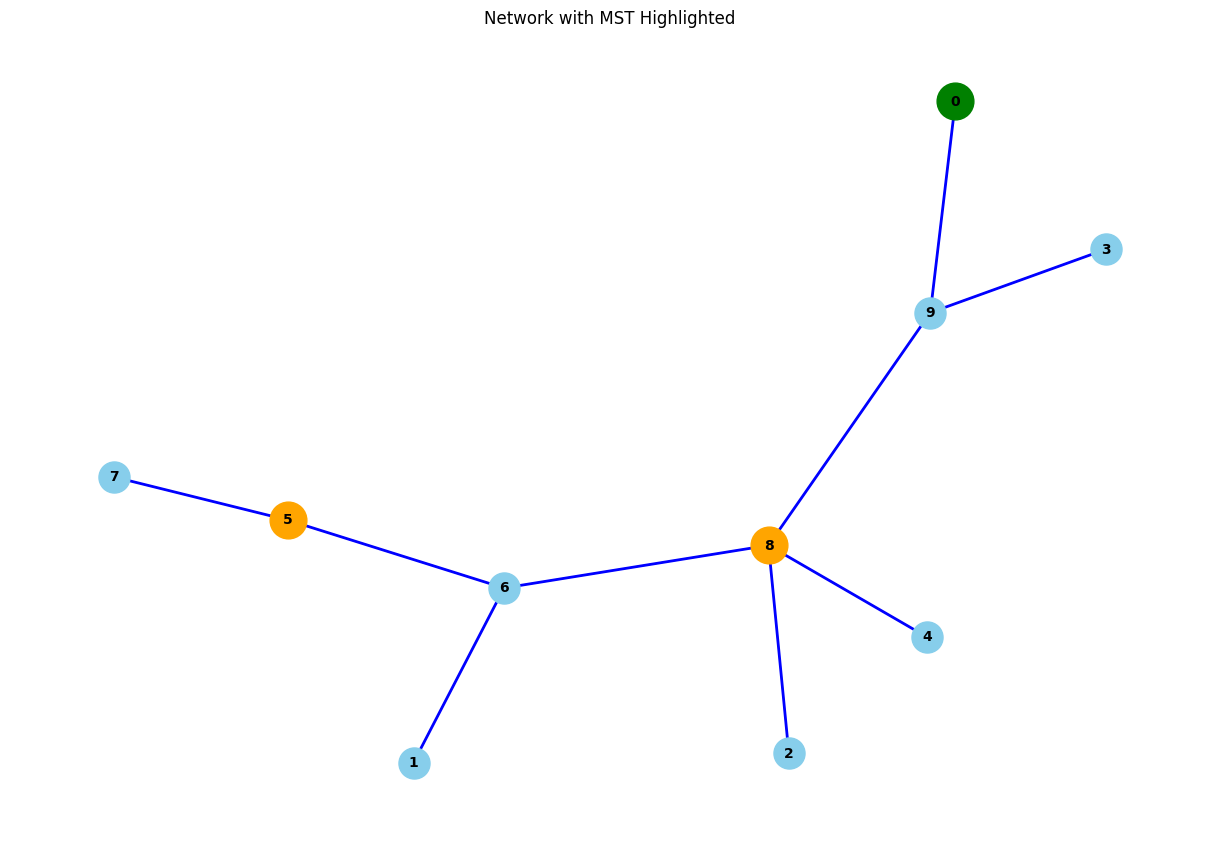

In [51]:
send_to_all_street_lights(TX_RANGE, NUM_NODES, NUM_STREET_LIGHTS, VERBOSE)

### Average Simulation

In [18]:
def run_simulations(num_simulations, tx_range, num_nodes, num_street_lights, verbose):
    # Listas para almacenar los resultados
    rpl_operation_results = []
    rpl_operation_second_approach_results = []
    rpl_projected_routes_results = []
    rpl_multicast_results = []

    for _ in range(num_simulations):
        rpl_operation_total_hops, rpl_operation_hops_to_root, rpl_operation_hops_from_root, rpl_operation_second_approach_total_hops, rpl_operation_second_approach_hops_to_root, rpl_operation_second_approach_hops_from_root, rpl_projected_routes_total_hops, rpl_multicast_total_hops = send_to_all_street_lights_using_all_protocols(tx_range, num_nodes, num_street_lights, verbose)

        # Almacenar los resultados en las listas
        rpl_operation_results.append([rpl_operation_total_hops, rpl_operation_hops_to_root, rpl_operation_hops_from_root])
        rpl_operation_second_approach_results.append([rpl_operation_second_approach_total_hops, rpl_operation_second_approach_hops_to_root, rpl_operation_second_approach_hops_from_root])
        rpl_projected_routes_results.append(rpl_projected_routes_total_hops)
        rpl_multicast_results.append(rpl_multicast_total_hops)

    # Calcular los promedios
    rpl_operation_averages = [sum(x) / num_simulations for x in zip(*rpl_operation_results)]
    rpl_operation_second_approach_averages = [sum(x) / num_simulations for x in zip(*rpl_operation_second_approach_results)]
    rpl_projected_routes_average = sum(rpl_projected_routes_results) / num_simulations
    proposed_solution_average = sum(rpl_multicast_results) / num_simulations

    # Imprimir los resultados promedio o realizar el análisis deseado
    if verbose:
        print(f"Number of simulations:  {num_simulations}\n")

        print(f"Number of nodes:  {num_nodes}\n")

        print(f"Number of street lights:  {num_street_lights}\n")

        print(f"Standard RPL Operation:   Average hops  |  Average number of hops from origin to the Root  |  From Root to destination ")
        print(f"Standard RPL Operation: {rpl_operation_averages[0]}, {rpl_operation_averages[1]}, {rpl_operation_averages[2]}\n")

        print(f"Standard RPL Operation alternative:   Average hops  |  Average number of hops from origin to the Root  |  From Root to destination ")
        print(f"Standard RPL Operation alternative: {rpl_operation_second_approach_averages[0]}, {rpl_operation_second_approach_averages[1]}, {rpl_operation_second_approach_averages[2]}\n")

        print(f"RPL Projected Routes:   Average hops")
        print(f"RPL Projected Routes: {rpl_projected_routes_average}\n")

        print(f"Proposed Solution:   Average hops")
        print(f"Proposed Solution: {proposed_solution_average}")

    return rpl_operation_averages[0], rpl_operation_averages[1], rpl_operation_averages[2], rpl_operation_second_approach_averages[0], rpl_operation_second_approach_averages[1], rpl_operation_second_approach_averages[2], rpl_projected_routes_average, proposed_solution_average

In [19]:
def print_results():
    print(f"Number of simulations: {NUM_SIMULATIONS}\n")

    print(f"Number of nodes: {NUM_NODES}\n")

    print(f"Number of street lights:  {NUM_STREET_LIGHTS}\n")

    print(f"Standard RPL Operation:   Average hops  |  Average number of hops from origin to the Root  |  From Root to destination ")
    print(f"Standard RPL Operation: {rpl_hops}, {rpl_hops_from_origin}, {rpl_hops_from_root}\n")

    print(f"Standard RPL Operation alternative:   Average hops  |  Average number of hops from origin to the Root  |  From Root to destination ")
    print(f"Standard RPL Operation alternative: {rpl_second_approach_hops}, {rpl_second_approach_hops_from_origin}, {rpl_second_approach_hops_from_root}\n")

    print(f"RPL Projected Routes:   Average hops")
    print(f"RPL Projected Routes: {projected_routes_hops}\n")

    print(f"Proposed Solution:   Average hops")
    print(f"Proposed Solution: {proposed_solution_hops}")

In [21]:
rpl_hops, rpl_hops_from_origin, rpl_hops_from_root, rpl_second_approach_hops, rpl_second_approach_hops_from_origin, rpl_second_approach_hops_from_root, projected_routes_hops, proposed_solution_hops =  run_simulations(NUM_SIMULATIONS, TX_RANGE, NUM_NODES, NUM_STREET_LIGHTS, VERBOSE)

In [22]:
print_results()

Number of simulations: 1000

Number of nodes: 10

Number of street lights:  2

Standard RPL Operation:   Average hops  |  Average number of hops from origin to the Root  |  From Root to destination 
Standard RPL Operation: 4.294, 2.166, 2.128

Standard RPL Operation alternative:   Average hops  |  Average number of hops from origin to the Root  |  From Root to destination 
Standard RPL Operation alternative: 4.891, 2.668, 2.469

RPL Projected Routes:   Average hops
RPL Projected Routes: 2.872

Proposed Solution:   Average hops
Proposed Solution: 2.872


### Simple Example 2

In [52]:
NUM_SIMULATIONS = 1000
TX_RANGE = 30 
NUM_NODES = 20
NUM_STREET_LIGHTS = 3
VERBOSE = False

Origin node: 17
Standard RPL Operation: 16, 11, 5
Standard RPL Operation alternative: 11, 6, 5
RPL Projected Routes: 10
Proposed Solution: 7


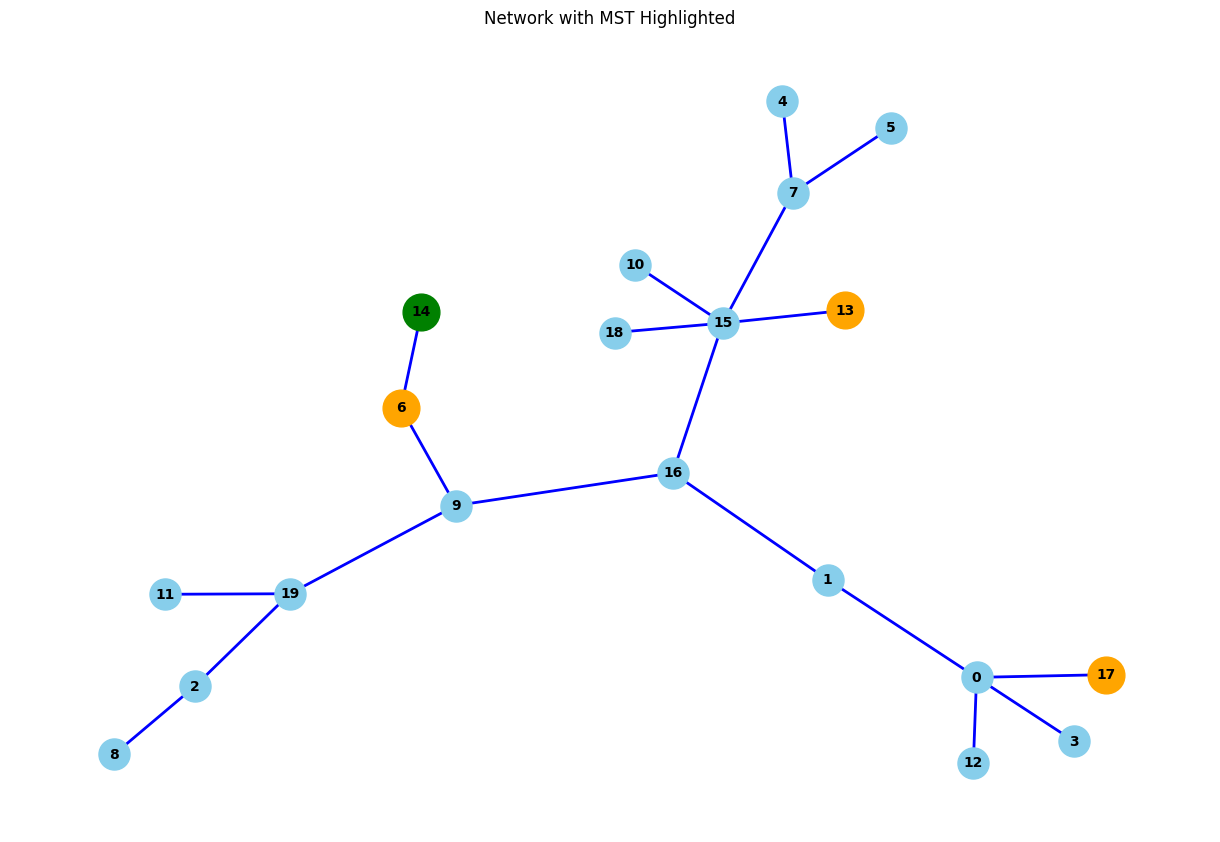

In [55]:
send_to_all_street_lights(TX_RANGE, NUM_NODES, NUM_STREET_LIGHTS, VERBOSE)

### Average Simulation 2

In [24]:
rpl_hops, rpl_hops_from_origin, rpl_hops_from_root, rpl_second_approach_hops, rpl_second_approach_hops_from_origin, rpl_second_approach_hops_from_root, projected_routes_hops, proposed_solution_hops =  run_simulations(NUM_SIMULATIONS, TX_RANGE, NUM_NODES, NUM_STREET_LIGHTS, VERBOSE)

In [25]:
print_results()

Number of simulations: 1000

Number of nodes: 20

Number of street lights:  3

Standard RPL Operation:   Average hops  |  Average number of hops from origin to the Root  |  From Root to destination 
Standard RPL Operation: 14.461, 7.143, 7.318

Standard RPL Operation alternative:   Average hops  |  Average number of hops from origin to the Root  |  From Root to destination 
Standard RPL Operation alternative: 11.982, 4.249, 7.781

RPL Projected Routes:   Average hops
RPL Projected Routes: 8.545

Proposed Solution:   Average hops
Proposed Solution: 6.421


## Diagrams

In [26]:
import matplotlib.pyplot as plt

In [27]:
def run_simulations_for_different_node_and_light_counts(num_simulations, tx_range, node_and_light_counts, verbose):
    results = {
        'num_nodes': [],
        'num_street_lights': [],
        'rpl_hops': [],
        'rpl_hops_from_origin': [],
        'rpl_hops_from_root': [],
        'rpl_second_approach_hops': [],
        'rpl_second_approach_hops_from_origin': [],
        'rpl_second_approach_hops_from_root': [],
        'projected_routes_hops': [],
        'proposed_solution_hops': []
    }

    for num_nodes, num_street_lights in node_and_light_counts:
        print(f"Running simulations for {num_nodes} nodes and {num_street_lights} street lights...")
        rpl_hops, rpl_hops_from_origin, rpl_hops_from_root, rpl_second_approach_hops, rpl_second_approach_hops_from_origin, rpl_second_approach_hops_from_root, projected_routes_hops, proposed_solution_hops = run_simulations(num_simulations, tx_range, num_nodes, num_street_lights, verbose)
        
        results['num_nodes'].append(num_nodes)
        results['num_street_lights'].append(num_street_lights)
        results['rpl_hops'].append(rpl_hops)
        results['rpl_hops_from_origin'].append(rpl_hops_from_origin)
        results['rpl_hops_from_root'].append(rpl_hops_from_root)
        results['rpl_second_approach_hops'].append(rpl_second_approach_hops)
        results['rpl_second_approach_hops_from_origin'].append(rpl_second_approach_hops_from_origin)
        results['rpl_second_approach_hops_from_root'].append(rpl_second_approach_hops_from_root)
        results['projected_routes_hops'].append(projected_routes_hops)
        results['proposed_solution_hops'].append(proposed_solution_hops)

    return results

In [28]:
def print_comparison_table(results):
    print("Comparison of Average Number of Hops for Different Protocols:")
    print(f"{'Num Nodes':<10} {'Num SL':<10} {'RPL Operation':<15} {'RPL Alt.':<15} {'Projected Routes':<20} {'Proposed Solution':<20}")
    for i in range(len(results['num_nodes'])):
        print(f"{results['num_nodes'][i]:<10} {results['num_street_lights'][i]:<10} {results['rpl_hops'][i]:<15.2f} {results['rpl_second_approach_hops'][i]:<15.2f} {results['projected_routes_hops'][i]:<20.2f} {results['proposed_solution_hops'][i]:<20.2f}")

In [29]:
def plot_results(results):
    plt.figure(figsize=(12, 8))

    plt.plot(results['num_nodes'], results['rpl_hops'], label='RPL Operation')
    plt.plot(results['num_nodes'], results['rpl_second_approach_hops'], label='RPL Operation Alt')
    plt.plot(results['num_nodes'], results['projected_routes_hops'], label='Projected Routes')
    plt.plot(results['num_nodes'], results['proposed_solution_hops'], label='Proposed Solution')

    plt.xlabel('Number of Nodes')
    plt.ylabel('Average Number of Hops')
    plt.title('Comparison of Average Number of Hops for Different Protocols')
    plt.legend()
    plt.grid(True)
    plt.show()

### Large network example

In [30]:
NUM_SIMULATIONS = 1000
TX_RANGE = 30 
VERBOSE = False
NODE_AND_LIGHT_COUNTS = [(100, 5), (200, 10), (400, 20), (600, 30), (800, 40), (1000, 50)]

In [31]:
results = run_simulations_for_different_node_and_light_counts(NUM_SIMULATIONS, TX_RANGE, NODE_AND_LIGHT_COUNTS, VERBOSE)

Running simulations for 100 nodes and 5 street lights...
Running simulations for 200 nodes and 10 street lights...
Running simulations for 400 nodes and 20 street lights...
Running simulations for 600 nodes and 30 street lights...
Running simulations for 800 nodes and 40 street lights...
Running simulations for 1000 nodes and 50 street lights...


In [32]:
print_comparison_table(results)

Comparison of Average Number of Hops for Different Protocols:
Num Nodes  Num SL     RPL Operation   RPL Alt.        Projected Routes     Proposed Solution   
100        5          73.23           46.60           39.31                21.57               
200        10         228.46          128.31          119.46               45.48               
400        20         667.66          350.61          344.42               93.18               
600        30         1195.48         623.20          618.30               141.90              
800        40         1849.02         950.58          929.03               188.46              
1000       50         2537.40         1285.88         1294.80              237.63              


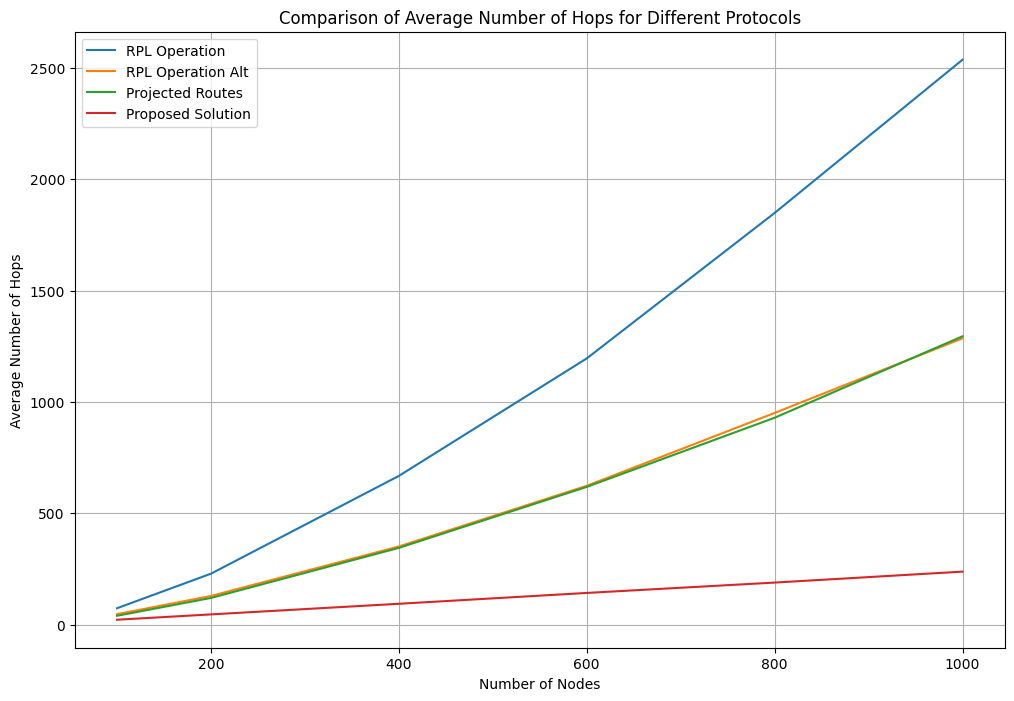

In [33]:
plot_results(results)